# Download

Mouse brain cells from Saunders et al (Drop-seq) http://dropviz.org/ --> Data

annotation R Data: annotation.BrainCellAtlas_Saunders_version_2018.04.01.rds (12K)

Hippocampus DGE  F_GRCm38.81.P60Hippocampus.raw.dge.txt.gz

Subcluster  F_GRCm38.81.P60Hippocampus.subcluster.assign.RDS

Mouse Brain cells from Zeisel et al (10X) http://mousebrain.org/downloads.html

L5_All.loom

# Preprocess

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import anndata2ri

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [2]:
tissue = "CB"

data_path = "data_MB/" + tissue

if not os.path.exists(data_path):
    os.makedirs(data_path)

# Drop-seq

datapath_Drop = "./Raw_data_Saunders"
    
dropviz_RDSname_dict = {"TH": "F_GRCm38.81.P60Thalamus.subcluster.assign.RDS",
                        "HC": "F_GRCm38.81.P60Hippocampus.subcluster.assign.RDS",
                        "CB": "F_GRCm38.81.P60Cerebellum_ALT.subcluster.assign.RDS"}
dropviz_dgename_dict = {"TH": "F_GRCm38.81.P60Thalamus.raw.dge.txt.gz",
                        "HC": "F_GRCm38.81.P60Hippocampus.raw.dge.txt.gz",
                        "CB": "F_GRCm38.81.P60Cerebellum_ALT.raw.dge.txt.gz"}

dropviz_anno = ro.r['readRDS'](datapath_Drop + "/annotation.BrainCellAtlas_Saunders_version_2018.04.01.RDS")
ro.r.assign("dropviz_anno", dropviz_anno)
ro.r.assign("tissue", tissue)
ro.r('''dropviz_anno_class <- dropviz_anno[which(dropviz_anno$tissue == tissue), c("class")]''')
dropviz_anno_class = list(ro.r("dropviz_anno_class"))
ro.r('''dropviz_anno_class_marker <- dropviz_anno[which(dropviz_anno$tissue == tissue), c("class_marker")]''')
dropviz_anno_class_marker = list(ro.r("dropviz_anno_class_marker"))
ro.r('''dropviz_anno_subcluster <- dropviz_anno[which(dropviz_anno$tissue == tissue), c("subcluster")]''')
dropviz_anno_subcluster = list(ro.r("dropviz_anno_subcluster"))

subcluster_assign = ro.r['readRDS'](datapath_Drop + "/" + dropviz_RDSname_dict[tissue])
ro.r.assign("subcluster_assign", subcluster_assign)
ro.r("subcluster_assign_name <- names(subcluster_assign)")
ro.r("subcluster_assign <- as.vector(subcluster_assign)")
subcluster_assign_name = list(ro.r("subcluster_assign_name"))
subcluster_assign = list(ro.r("subcluster_assign"))

meta_dropseq_dict = pd.DataFrame({"class": dropviz_anno_class, "marker": dropviz_anno_class_marker}, index=dropviz_anno_subcluster)
meta_dropseq_dict["subclass"] = meta_dropseq_dict["class"] + " (" + meta_dropseq_dict["marker"] + ")"

meta_dropseq = pd.DataFrame({"subcluster": subcluster_assign}, index=subcluster_assign_name)
meta_dropseq["drop_class"] = meta_dropseq_dict.loc[list(meta_dropseq["subcluster"].values)]["class"].values
meta_dropseq["drop_subclass"] = meta_dropseq_dict.loc[list(meta_dropseq["subcluster"].values)]["subclass"].values
meta_dropseq["drop_subcluster"] = (meta_dropseq["drop_class"] + "-" + meta_dropseq["subcluster"]).astype(str)

ro.r['library']("DropSeq.util")
ro.r['library']("Seurat")
ro.r['library']("SingleCellExperiment")
ro.r.assign("dge.path", datapath_Drop + "/" + dropviz_dgename_dict[tissue])
ro.r('''dge <- loadSparseDge(dge.path) ''')
ro.r("sce <- CreateSeuratObject(counts = dge)")
ro.r("sce <- as.SingleCellExperiment(sce)")

anndata2ri.activate()
adata_dropseq = ro.r('as(sce, "SingleCellExperiment")')
adata_dropseq = adata_dropseq[meta_dropseq.index]


# 10X

datapath_10X = "./Raw_data_Zeisel"

tissuename_10X_dict = {"TH": "Thal", "HC": "HC", "CB": "CB"}

adata_10X = sc.read_loom(datapath_10X + "/l5_all.loom")

meta_10X = adata_10X.obs[["Tissue", "Class", "Clusters"]]
meta_10X["subclass"] = meta_10X["Class"] + "_" + meta_10X["Clusters"].astype(str)

sub_meta_10X = meta_10X[meta_10X.Tissue == tissuename_10X_dict[tissue]]
sub_adata_10X = adata_10X[meta_10X.Tissue == tissuename_10X_dict[tissue]]

sub_adata_10X = sub_adata_10X[~sub_adata_10X.obs.index.duplicated(), ~sub_adata_10X.var.index.duplicated()]
sub_meta_10X = sub_meta_10X[~sub_meta_10X.index.duplicated()]

adata_10X = sub_adata_10X

meta_dropseq["method"] = "Drop"
sub_meta_10X["method"] = "10X"
meta = pd.concat([meta_dropseq, sub_meta_10X])
meta.to_pickle(os.path.join(data_path, "meta_raw.pkl"))

adata_dropseq.obs = adata_dropseq.obs[['ident']]
adata_dropseq.write(filename=os.path.join(data_path, "adata_dropseq.h5ad"))
sub_adata_10X.write(filename=os.path.join(data_path, "adata_10X.h5ad"))

R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.13.6 using 22 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Loading required package: Matrix

R[write to console]: 
Seurat v4 will be going to CRAN in the near future;
 for more details, please visit https://satijalab.org/seurat/v4_changes


R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to 

... storing 'Reads Mapped Confidently to Exonic Regions' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Reads Mapped Confidently to Intergenic Regions' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Reads Mapped Confidently to Intronic Regions' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Reads Mapped Confidently to Transcriptome' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Region' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleIndex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleOK' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Sample_Index' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SeqComment' as categorical
Trying to set attribute `.obs` 

# Integration using Portal

In [3]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Create a folder for saving results
result_path = "result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [4]:
model = portal.model.Model(training_steps=2000, lambdacos=15.0)
model.preprocess(adata_dropseq, adata_10X) # perform preprocess and PCA
model.train() # train the model
model.eval() # get integrated latent representation of cells

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Normalizing and scaling...


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Dimensionality reduction via PCA...
Begining time:  Thu Mar 17 20:41:36 2022
step 0, loss_D=9.556219, loss_GAN=2.906622, loss_AE=260.116089, loss_cos=29.515400, loss_LA=207.128677
step 200, loss_D=2.598508, loss_GAN=3.560721, loss_AE=9.093377, loss_cos=5.291987, loss_LA=2.438880
step 400, loss_D=2.475666, loss_GAN=3.091831, loss_AE=5.584288, loss_cos=3.221293, loss_LA=1.344176
step 600, loss_D=2.809396, loss_GAN=2.995210, loss_AE=4.604313, loss_cos=2.587498, loss_LA=1.096710
step 800, loss_D=2.482383, loss_GAN=3.091920, loss_AE=3.773004, loss_cos=2.127327, loss_LA=0.725290
step 1000, loss_D=2.477369, loss_GAN=3.009437, loss_AE=3.068430, loss_cos=2.102551, loss_LA=0.495042
step 1200, loss_D=2.446446, loss_GAN=2.612375, loss_AE=2.606275, loss_cos=1.659568, loss_LA=0.385495
step 1400, loss_D=2.738665, loss_GAN=2.848250, loss_AE=2.812898, loss_cos=1.880576, loss_LA=0.394464
step 1600, loss_D=2.547716, loss_GAN=2.761175, loss_AE=2.700958, loss_cos=1.876387, loss_LA=0.434538
step 1800, loss_

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Thu Mar 17 20:42:23 2022 Finding Nearest Neighbors
Thu Mar 17 20:42:23 2022 Building RP forest with 12 trees
Thu Mar 17 20:42:25 2022 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
Thu Mar 17 20:42:39 2022 Finished Nearest Neighbor Search
Thu Mar 17 20:42:41 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


... storing 'subcluster' as categorical
... storing 'drop_class' as categorical
... storing 'drop_subclass' as categorical
... storing 'drop_subcluster' as categorical
... storing 'method' as categorical
... storing 'Tissue' as categorical
... storing 'Class' as categorical
... storing 'subclass' as categorical


Thu Mar 17 20:43:06 2022 Finished embedding


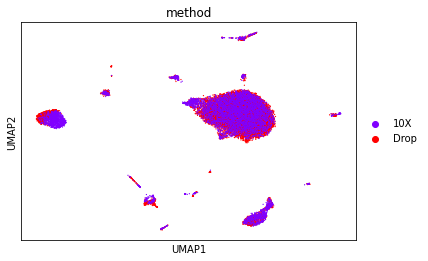

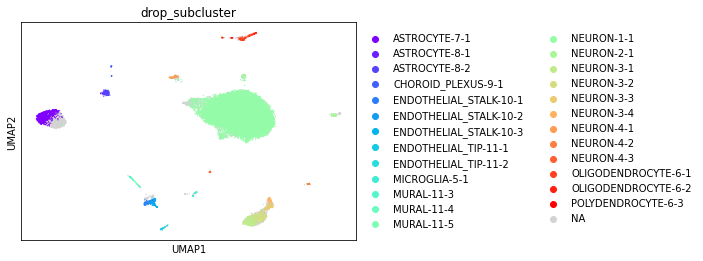

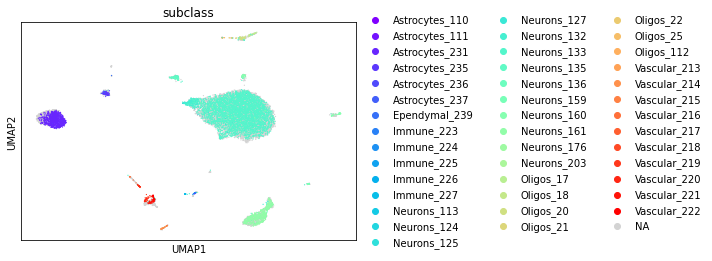

In [5]:
# The integration result can be visualized by portal.utils.plot_UMAP
portal.utils.plot_UMAP(model.latent, meta, colors=["method", "drop_subcluster", "subclass"], save=True, result_path=result_path)